# Классификация узлов сети с помощью графовой нейронной сети, использующей атрибуты узлов

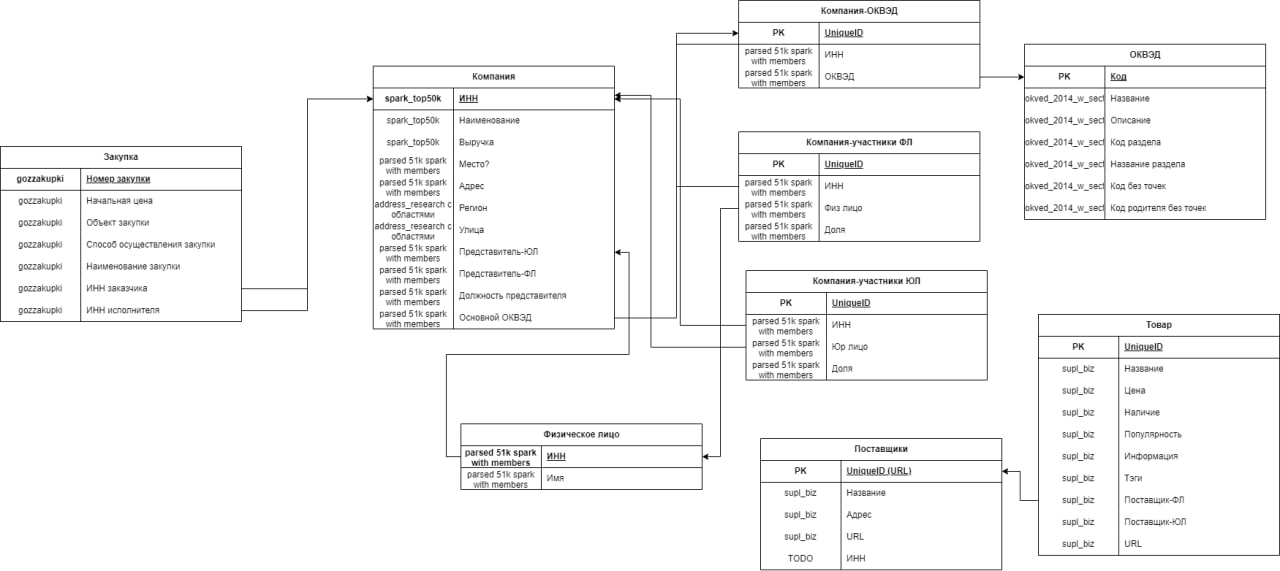

In [176]:
import sqlite3
import networkx as nx
import matplotlib.pyplot as plt
import time

import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.data import Data

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [51]:
conn = sqlite3.connect('okved_20230329.sqlite3')
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
[table[0] for table in tables]

['natural_person',
 'supplier',
 'okved',
 'legal_entity',
 'product',
 'company_to_okved',
 'company_to_natural_member',
 'company_to_legal_member',
 'procurement']

In [52]:
# В моем случае для узлов мне понадобятся:
# legal_entity
# procurement
# natural_person
# okved

# для ребер понадобятся данные из:
# company_to_natural_member
# company_to_legal_member
# company_to_okved

tables = ["legal_entity", "procurement", "natural_person", "okved"]

In [53]:
dict_of_tables_to_columns = {}
for table in tables:
    cursor.execute(f"PRAGMA table_info({table})")
    columns = cursor.fetchall()
    dict_of_tables_to_columns[table] = [column[1] for column in columns]

print('\033[1m' + '\033[4m' + 'Словарь, где ключ - название таблицы, а значение - список названий характеристик:\n' + '\033[0m') 
for k,v in dict_of_tables_to_columns.items():
    print('\033[1m' + k + '\033[0m')
    print(v)
    print()

Словарь, где ключ - название таблицы, а значение - список названий характеристик:

legal_entity
['inn', 'name', 'revenue', 'location', 'address', 'region', 'street', 'post', 'natural_representative_inn', 'legal_representative_inn', 'main_okved_code']

procurement
['id', 'start_price', 'object', 'method', 'name', 'customer_inn', 'executor_inn']

natural_person
['inn', 'name']

okved
['code', 'name', 'info', 'section_code', 'section_name', 'numeric_code', 'parent_numeric_code']



In [54]:
# узлы
G = nx.Graph()

for table,columns in dict_of_tables_to_columns.items():
    cursor.execute(f"SELECT * FROM {table}")
    table_data = cursor.fetchall()
    
    if table == 'legal_entity': 
        table_data = table_data[:5000]
        
    print(table, len(table_data))
    for i, row in enumerate(table_data):
        node_attributes = {attr: row[j] for j, attr in enumerate(columns)}
        node_attributes['type'] = table
        node_name = f"{table}_{i}"
        
        G.add_node(node_name, **node_attributes)
len(G)

legal_entity 5000
procurement 24807
natural_person 72082
okved 2636


104525

## Cвязываю узлы на основе данных из атрибутов узлов

In [55]:
%%time

legal_entity_to_procurement = {}

for node, data in G.nodes(data=True):
    if data.get('type') == 'procurement':
        customer_inn = data.get('customer_inn')
        executor_inn = data.get('executor_inn')
        legal_entity_to_procurement.setdefault(customer_inn, []).append(node)
        legal_entity_to_procurement.setdefault(executor_inn, []).append(node)
    
legal_entity_to_inn = {data['inn']: node for node, data in G.nodes(data=True) if data.get('type') == 'legal_entity'}

for inn, legal_entity in legal_entity_to_procurement.items():
    if inn in legal_entity_to_inn:
        for company in legal_entity:
            if G.has_node(company): G.add_edge(legal_entity_to_inn[inn], company)

CPU times: total: 109 ms
Wall time: 113 ms


In [56]:
len(G.edges())

18368

In [57]:
len(list(nx.isolates(G)))

87243

In [58]:
%%time

legal_entity_to_okved = {data['main_okved_code']: node for node, data in G.nodes(data=True) if data.get('type') == 'legal_entity'}
okved_nodes = {data['code']: node for node, data in G.nodes(data=True) if data.get('type') == 'okved'}
for okved1, legal_entity in legal_entity_to_okved.items():
    if okved1 in okved_nodes:
        G.add_edge(legal_entity, okved_nodes[okved1])

CPU times: total: 31.2 ms
Wall time: 42 ms


In [59]:
len(G.edges()), len(G), len(list(nx.isolates(G)))

(19053, 104525, 86046)

In [60]:
%%time
legal_entity_to_natural = {data['natural_representative_inn']: node for node, data in G.nodes(data=True) if data.get('type') == 'legal_entity'}
legal_entity_to_legal = {data['legal_representative_inn']: node for node, data in G.nodes(data=True) if data.get('type') == 'legal_entity'}
natural_person = {data['inn']: node for node, data in G.nodes(data=True) if data.get('type') == 'natural_person'}

for natural_inn, legal_entity in legal_entity_to_natural.items():
    if natural_inn in natural_person:
        G.add_edge(legal_entity, natural_person[natural_inn])

for legal_inn, legal_entity in legal_entity_to_legal.items():
    if legal_inn in legal_entity_to_inn:
        G.add_edge(legal_entity, legal_entity_to_inn[legal_inn])

CPU times: total: 62.5 ms
Wall time: 70 ms


In [61]:
len(G.edges()), len(G), len(list(nx.isolates(G)))

(23326, 104525, 79212)

In [62]:
sum([1 for edge in G.edges(data=True) if edge[2]]) # =0 так и должно быть, так как связываю узлы на основе имеющихся данных

0

## Дальше связываю узлы только с помощью новых таблиц

In [63]:
%%time

legal_entity_nodes = {data['inn']: node for node, data in G.nodes(data=True) if data.get('type') == 'legal_entity'}

cursor.execute("SELECT * FROM company_to_legal_member")
company_to_legal_member = cursor.fetchall()

for company_inn, member_inn, share in company_to_legal_member:
    if (company_inn in legal_entity_nodes) and (member_inn in legal_entity_nodes):
        G.add_edge(legal_entity_nodes[company_inn], legal_entity_nodes[member_inn], share=share)

CPU times: total: 62.5 ms
Wall time: 68.8 ms


In [64]:
len(G.edges()), len(list(nx.isolates(G)))

(23922, 79125)

In [65]:
%%time
natural_person_nodes = {data['inn']: node for node, data in G.nodes(data=True) if data.get('type') == 'natural_person'}

cursor.execute("SELECT * FROM company_to_natural_member")
company_to_natural_member = cursor.fetchall()

for company_inn, member_inn, share in company_to_natural_member:
    if (company_inn in legal_entity_nodes) and (member_inn in natural_person_nodes):
        G.add_edge(legal_entity_nodes[company_inn], natural_person_nodes[member_inn], share=share)

CPU times: total: 188 ms
Wall time: 170 ms


In [66]:
len(G.edges()), len(list(nx.isolates(G)))

(26822, 76671)

In [67]:
%%time
okved_nodes = {data['code']: node for node, data in G.nodes(data=True) if data.get('type') == 'okved'}

cursor.execute("SELECT * FROM company_to_okved")
company_to_okved = cursor.fetchall()

for company_inn, okved_code in company_to_okved:
    if (company_inn in legal_entity_nodes) and (okved_code in okved_nodes):
        G.add_edge(legal_entity_nodes[company_inn], okved_nodes[okved_code])

CPU times: total: 1.81 s
Wall time: 1.85 s


In [68]:
len(G.edges()), len(G), len(list(nx.isolates(G)))

(120862, 104525, 75073)

In [69]:
sum([1 for edge in G.edges(data=True) if edge[2]])

4434

In [70]:
len(list(nx.isolates(G)))/len(G)*100
# процент изолированных узлов, остальные удаляю

71.82300884955752

In [71]:
G.remove_nodes_from(list(nx.isolates(G)))

In [72]:
len(G)

29452

In [73]:
cursor.close()
conn.close()

In [74]:
nx.write_gpickle(G, "big_graph.pkl")

In [75]:
G = nx.read_gpickle("big_graph.pkl")

node_types = {node: data['type'] for node, data in G.nodes(data=True)}
type_counts = {}
for node, node_type in node_types.items():
    type_counts[node_type] = type_counts.get(node_type, 0) + 1

for node_type, count in type_counts.items():
    print(f"Тип {node_type}: {count/len(G)}")
    
len(G)

Тип legal_entity: 0.16718728779030287
Тип procurement: 0.5393182126850469
Тип natural_person: 0.2243650685861741
Тип okved: 0.06912943093847616


29452

In [76]:
typee=[]
for node, data in G.nodes(data=True):
    if data['type']=='legal_entity' and data['type'] not in typee: 
        typee.append(data['type'])
        print(node, data)
        print()
    elif data['type']=='procurement' and data['type'] not in typee: 
        typee.append(data['type'])
        print(node, data)
        print()
    elif data['type']=='natural_person' and data['type'] not in typee: 
        typee.append(data['type'])
        print(node, data)
        print()
        
    elif data['type']=='okved' and data['type'] not in typee: 
        typee.append(data['type'])
        print(node, data)
        print()

legal_entity_0 {'inn': '7706107510', 'name': 'ПАО "НК "РОСНЕФТЬ"', 'revenue': 8000000000000.0, 'location': 'ГОРОД МОСКВА', 'address': '115035, ГОРОД МОСКВА, НАБ. СОФИЙСКАЯ, Д.26/1', 'region': 'МОСКВА', 'street': 'НАБ СОФИЙСКАЯ', 'post': 'ГЛАВНЫЙ ИСПОЛНИТЕЛЬНЫЙ\nДИРЕКТОР', 'natural_representative_inn': '770370393938', 'legal_representative_inn': None, 'main_okved_code': '06.10.1', 'type': 'legal_entity'}

procurement_0 {'id': '32110356755', 'start_price': 447993.0, 'object': 'Оказание   услуг  по   организации  и  проведению   мероприятий   в пансионате  «Морозовка»', 'method': 'СБ-АСТ: Закупка у единственного поставщика', 'name': 'Оказание   услуг  по   организации  и  проведению   мероприятий   в пансионате  «Морозовка»', 'customer_inn': '5044000102', 'executor_inn': '7736050003', 'type': 'procurement'}

natural_person_0 {'inn': '770370393938', 'name': 'СЕЧИН ИГОРЬ ИВАНОВИЧ', 'type': 'natural_person'}

okved_1 {'code': '01.1', 'name': 'Выращивание однолетних культур', 'info': 'Эта гру

In [77]:
location = set()
region = set()

for node, data in G.nodes(data=True):
    if data['type']=='legal_entity': 
        location.add(data['location'])
        region.add(data['region'])

print(len(region))
print(region)

80
{'УДМУРТСКАЯ РЕСП', 'ТУЛЬСКАЯ ОБЛ', 'ПРИМОРСКИЙ КРАЙ', 'ТАМБОВСКАЯ ОБЛ', 'СЕВАСТОПОЛЬ', 'РЕСП ХАКАСИЯ', 'РЕСП САХА', 'МОСКВА', 'КАМЧАТСКИЙ КРАЙ', 'ВОЛГОГРАДСКАЯ ОБЛ', 'КАЛИНИНГРАДСКАЯ ОБЛ', 'КРАСНОДАРСКИЙ КРАЙ', 'ЯРОСЛАВСКАЯ ОБЛ', 'МАГАДАНСКАЯ ОБЛ', 'РЕСП МАРИЙ ЭЛ', 'ТОМСКАЯ ОБЛ', 'РЯЗАНСКАЯ ОБЛ', 'САНКТ-ПЕТЕРБУРГ', 'АЛТАЙСКИЙ КРАЙ', 'НОВГОРОДСКАЯ ОБЛ', 'ЛИПЕЦКАЯ ОБЛ', 'ЗАБАЙКАЛЬСКИЙ КРАЙ', 'ПЕНЗЕНСКАЯ ОБЛ', 'ОМСКАЯ ОБЛ', 'КИРОВСКАЯ ОБЛ', 'РЕСП ИНГУШЕТИЯ', 'РЕСП АЛТАЙ', 'РЕСП БАШКОРТОСТАН', 'ТВЕРСКАЯ ОБЛ', 'БЕЛГОРОДСКАЯ ОБЛ', 'РЕСП БУРЯТИЯ', 'РЕСП МОРДОВИЯ', 'ПЕРМСКИЙ КРАЙ', 'РЕСП КРЫМ', 'КРАСНОЯРСКИЙ КРАЙ', None, 'БРЯНСКАЯ ОБЛ', 'ОРЛОВСКАЯ ОБЛ', 'СТАВРОПОЛЬСКИЙ КРАЙ', 'РОСТОВСКАЯ ОБЛ', 'НИЖЕГОРОДСКАЯ ОБЛ', 'КЕМЕРОВСКАЯ ОБЛ', 'САХАЛИНСКАЯ ОБЛ', 'ВЛАДИМИРСКАЯ ОБЛ', 'АРХАНГЕЛЬСКАЯ ОБЛ', 'НОВОСИБИРСКАЯ ОБЛ', 'ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУ- ЮГРА', 'САМАРСКАЯ ОБЛ', 'КАЛУЖСКАЯ ОБЛ', 'ТЮМЕНСКАЯ ОБЛ', 'СВЕРДЛОВСКАЯ ОБЛ', 'МУРМАНСКАЯ ОБЛ', 'РЕСП КОМИ', 'КУРГАНСКАЯ ОБЛ', 'САРАТОВСКАЯ ОБЛ',

In [78]:
lnp = [degree for node, degree in dict(G.degree()).items() if G.nodes[node]['type'] == 'natural_person']
sum(lnp)/len(lnp), len(lnp)

(1.0747578692493946, 6608)

In [79]:
lp = [degree for node, degree in dict(G.degree()).items() if G.nodes[node]['type'] == 'procurement']
sum(lp)/len(lp), len(lp)

(1.1563837824225636, 15884)

In [80]:
len([degree for node, degree in dict(G.degree()).items() if G.nodes[node]['type'] == 'procurement' and degree > 1])


2484

In [81]:
lle = [degree for node, degree in dict(G.degree()).items() if G.nodes[node]['type'] == 'legal_entity']
sum(lle)/len(lle), len(lle)

(24.680950446791226, 4924)

In [82]:
lo =[degree for node, degree in dict(G.degree()).items() if G.nodes[node]['type'] == 'okved']
sum(lo)/len(lo), len(lo)

(46.52504911591355, 2036)

In [83]:
len([degree for node, degree in dict(G.degree()).items() if G.nodes[node]['type'] == 'okved' and degree > 5])


1350

In [84]:
nodes_to_remove = [node for node, degree in dict(G.degree()).items() 
                   if degree < 2 and 
                   (G.nodes[node]['type'] == 'okved' or degree <= 5) and 
                   (G.nodes[node]['type'] != 'natural_person' or random.random() > 0.4) and
                   G.nodes[node]['type'] != 'legal_entity'
                  ]
G.remove_nodes_from(nodes_to_remove)

node_types = {node: data['type'] for node, data in G.nodes(data=True)}
type_counts = {}
for node, node_type in node_types.items():
    type_counts[node_type] = type_counts.get(node_type, 0) + 1

for node_type, count in type_counts.items():
    print(f"Тип {node_type}: {count/len(G)}, {count}")

Тип legal_entity: 0.41336467427803897, 4924
Тип procurement: 0.20852921423774345, 2484
Тип natural_person: 0.23127938213566152, 2755
Тип okved: 0.1468267293485561, 1749


In [85]:
len(G.edges()), len(G), len(list(nx.isolates(G)))

(103322, 11912, 27)

In [86]:
G.remove_nodes_from(list(nx.isolates(G)))

In [87]:
len(G), len(max(nx.connected_components(G), key=len))

(11885, 11879)

In [88]:
G = G.subgraph(max(nx.connected_components(G), key=len))

## Векторизация

In [89]:
node_types = {node: data['type'] for node, data in G.nodes(data=True)}
type_counts = {}
for node, node_type in node_types.items():
    type_counts[node_type] = type_counts.get(node_type, 0) + 1

for node_type, count in type_counts.items():
    print(f"Тип {node_type}: {count/len(G)}")
    
len(G)

Тип legal_entity: 0.41198754103880797
Тип procurement: 0.20910851081740886
Тип natural_person: 0.23166933243539017
Тип okved: 0.14723461570839297


11879

# **Data()**

In [90]:
%%time

def process_node_attributes(G):
    all_keys = set()
    for _, data in G.nodes(data=True):
        all_keys.update(data.keys())

    categorical_data = {key: set() for key in all_keys}
    for node, data in G.nodes(data=True):
        for key in all_keys:
            value = str(data.get(key, 'None'))
            categorical_data[key].add(value)

    encoders = {key: LabelEncoder().fit(list(values)) for key, values in categorical_data.items()}

    features = []
    targets = []
    for _, data in G.nodes(data=True):
        node_features = []
        for key in all_keys:
            if key == 'region':
                continue
            value = str(data.get(key, 'None'))
            if key in encoders:
                encoded_value = encoders[key].transform([value])[0]
                node_features.append(encoded_value)
            else:
                node_features.append(float(value))
        features.append(node_features)

        region_value = str(data.get('region', 'None'))
        targets.append(region_value)

    return np.array(features), np.array(targets), encoders

features, targets, encoders = process_node_attributes(G)

CPU times: total: 19min 11s
Wall time: 19min 15s


In [93]:
def create_torch_geometric_data(G, features, targets, encoders):
    node_mapping = {node: i for i, node in enumerate(G.nodes())}
    edge_index = torch.tensor([[node_mapping[start], node_mapping[end]] for start, end in G.edges()], 
                              dtype=torch.long).t().contiguous()
    x = torch.tensor(features, dtype=torch.float)
    y = torch.tensor(encoders['region'].transform(targets), dtype=torch.long)
    return Data(x=x, edge_index=edge_index, y=y)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

data = create_torch_geometric_data(G, scaled_features, targets, encoders)

In [94]:
data

Data(x=[11879, 23], edge_index=[2, 103319], y=[11879])

In [95]:
data.x

tensor([[ 0.4313, -0.0907, -2.3206,  ..., -0.1241,  0.4292,  1.7130],
        [ 0.4313,  0.5724, -0.8473,  ..., -0.1315,  0.4292,  5.1352],
        [ 0.4313, -0.8055, -1.0252,  ..., -0.1204,  0.4292,  0.2870],
        ...,
        [ 0.4313,  0.9661,  0.6665,  ..., -0.5600,  0.4292, -0.4735],
        [ 0.4313,  0.9661,  0.6665,  ..., -0.5600,  0.4292, -0.4735],
        [ 0.4313,  0.9661,  0.6665,  ..., -0.5600,  0.4292, -0.4735]])

In [96]:
data.edge_index

tensor([[    0,     0,     0,  ...,  4893,  4893,  4893],
        [  317, 10804, 10803,  ..., 11658, 11668, 11676]])

# SAGEConv()

In [103]:
from tqdm import tqdm
from torch_geometric.nn import SAGEConv

In [104]:
data

Data(x=[11879, 23], edge_index=[2, 103319], y=[11879])

In [107]:
class GraphSAGEModel(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats, num_classes):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(in_feats, hidden_feats, aggr='mean')
        self.conv2 = SAGEConv(hidden_feats, out_feats, aggr='mean')
        self.fc = nn.Linear(out_feats, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        h = self.conv1(x, edge_index)
        h = F.relu(h)
        h = self.conv2(h, edge_index)
        embeddings = h  # Эмбеддинги после прохождения через сверточные слои
        h = self.fc(h)
        return h, embeddings

# Параметры модели
in_feats = data.x.shape[1]  # Примерное количество признаков после предобработки
hidden_feats = 16
out_feats = 32
num_classes = len(region)

# Создание модели
model = GraphSAGEModel(in_feats, hidden_feats, out_feats, num_classes)

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Функция обучения модели
def train_model(model, data, criterion, optimizer, num_epochs=300):
    model.train()
    for epoch in tqdm(range(num_epochs)):
        optimizer.zero_grad()
        output, _ = model(data)
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 50 == 0:
            print(f'Epoch {epoch + 1}, Loss = {loss.item()}')


train_model(model, data, criterion, optimizer)

 18%|██████████████▎                                                                  | 53/300 [00:02<00:13, 18.84it/s]

Epoch 50, Loss = 0.8756992816925049


 35%|███████████████████████████▋                                                    | 104/300 [00:05<00:10, 18.35it/s]

Epoch 100, Loss = 0.45301035046577454


 51%|████████████████████████████████████████▌                                       | 152/300 [00:08<00:08, 16.89it/s]

Epoch 150, Loss = 0.26870307326316833


 67%|█████████████████████████████████████████████████████▊                          | 202/300 [00:11<00:06, 14.37it/s]

Epoch 200, Loss = 0.19068625569343567


 84%|███████████████████████████████████████████████████████████████████▏            | 252/300 [00:15<00:03, 14.41it/s]

Epoch 250, Loss = 0.15415841341018677


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:18<00:00, 15.94it/s]

Epoch 300, Loss = 0.1337338238954544


In [108]:
from sklearn.metrics import accuracy_score

# Предсказание и вычисление метрик
def evaluate_model(model, data):
    model.eval()
    with torch.no_grad():
        outputs, embeddings = model(data)
        predictions = torch.argmax(outputs, dim=1)
        targets = data.y
        accuracy = accuracy_score(targets.numpy(), predictions.numpy())
        print(f'Accuracy: {accuracy}')
    return embeddings, predictions.numpy()

embeddings1, predictions = evaluate_model(model, data)

Accuracy: 0.9777759070628841


In [109]:
embeddings1.shape

torch.Size([11879, 32])

In [110]:
import torch
from sklearn.metrics import classification_report

true_labels = data.y.cpu().numpy() # Истинные метки классов
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7016
           1       0.96      1.00      0.98        24
           2       1.00      0.93      0.97        15
           3       1.00      1.00      1.00        18
           4       1.00      1.00      1.00         9
           5       1.00      1.00      1.00        51
           6       1.00      0.94      0.97        18
           7       1.00      0.97      0.98        32
           8       1.00      0.50      0.67        30
           9       0.97      1.00      0.98        28
          10       0.78      1.00      0.88        57
          11       0.00      0.00      0.00         1
          12       0.80      0.73      0.76        11
          13       1.00      0.89      0.94         9
          14       0.98      1.00      0.99        56
          15       0.59      0.64      0.61        36
          16       0.65      0.51      0.57        39
          17       0.94    

D:\Program Files\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


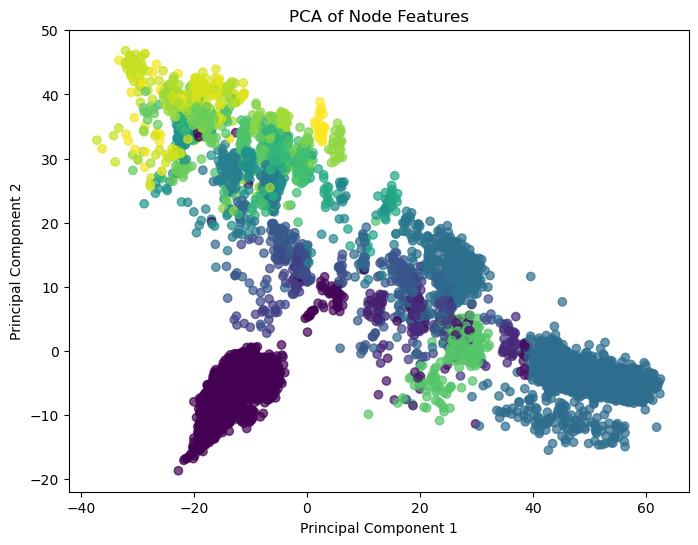

In [111]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings1)

colors = data.y

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7, c=colors)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Node Features')
plt.show()

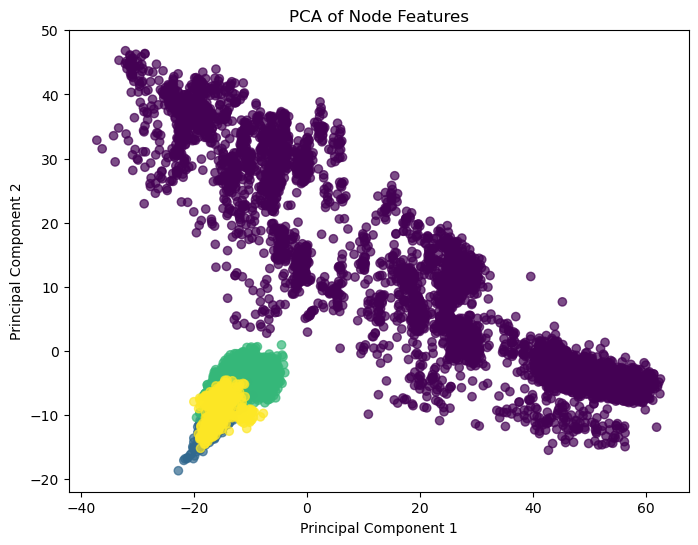

In [112]:
node_labelling = {
    'legal_entity': 0,
    'procurement': 1,
    'natural_person': 2,
    'okved': 3
}
labels = [node_labelling[G.nodes[node]["type"]] for node in G.nodes()]


pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings1)

colors = labels

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7, c=colors)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Node Features')
plt.show()

In [117]:
node_labelling = {
    'legal_entity': 0,
    'procurement': 1,
    'natural_person': 2,
    'okved': 3
}
# labels = [node_labelling[G.nodes[node]["type"]] for node in G.nodes()]
labels = data.y
X_train, X_test, y_train, y_test = train_test_split(embeddings1, labels, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

accuracy = clf.score(X_test, y_test)
accuracy

0.9726430976430976

In [121]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
    
labels = data.y
X_train, X_test, y_train, y_test = train_test_split(embeddings1, labels, test_size=0.2, random_state=42)

X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

input_size = X_train.shape[1]
hidden_size = 32
output_size = len(set(labels))
model = NeuralNetwork(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in tqdm(range(40)):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    accuracy = accuracy_score(y_test, predicted.numpy())
accuracy

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [02:31<00:00,  3.79s/it]


0.9713804713804713

In [122]:
embeddings1

tensor([[ 12.6391,  13.7476,  11.4797,  ...,   1.9471, -10.1454, -12.2399],
        [  6.9424,  13.4880,   5.4556,  ...,  -0.8105,  -9.6952,  -7.8476],
        [  8.6907,  13.9729,   5.7689,  ...,  -0.9816, -11.7273,  -6.8932],
        ...,
        [ -6.0230,   7.1050,   9.5045,  ...,   2.5672,   1.9233, -11.1897],
        [ -5.9523,   7.5505,   9.2428,  ...,   2.5679,   1.3889, -10.8781],
        [ -3.1391,   6.0634,   8.2389,  ...,   4.5771,   1.8638, -10.3128]])


# conv.AGNNConv

In [123]:
data

Data(x=[11879, 23], edge_index=[2, 103319], y=[11879])

In [126]:
from torch_geometric.nn import AGNNConv

class AGNN(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats, num_classes):
        super(AGNN, self).__init__()
        self.conv1 = AGNNConv()
        self.linear1 = nn.Linear(in_feats, hidden_feats)
        self.conv2 = AGNNConv()
        self.linear2 = nn.Linear(hidden_feats, out_feats)
        self.fc = nn.Linear(out_feats, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        h = self.linear1(x)
        h = self.conv1(h, edge_index)
        h = F.relu(h)
        h = self.linear2(h)
        h = self.conv2(h, edge_index)
        embeddings = h  # Эмбеддинги после прохождения через сверточные слои
        h = self.fc(h)
        return h, embeddings

# Параметры модели
in_feats = data.x.shape[1]  # Примерное количество признаков после предобработки
hidden_feats = 16
out_feats = 32
num_classes = len(region)

# Создание модели
model = AGNN(in_feats, hidden_feats, out_feats, num_classes)

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Функция обучения модели
def train_model(model, data, criterion, optimizer, num_epochs=300):
    model.train()
    for epoch in tqdm(range(num_epochs)):
        optimizer.zero_grad()
        output, _ = model(data)
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 50 == 0:
            print(f'Epoch {epoch + 1}, Loss = {loss.item()}')

train_model(model, data, criterion, optimizer)

 17%|█████████████▊                                                                   | 51/300 [00:07<00:35,  6.93it/s]

Epoch 50, Loss = 1.1836775541305542


 34%|██████████████████████████▉                                                     | 101/300 [00:14<00:29,  6.79it/s]

Epoch 100, Loss = 0.6719573736190796


 50%|████████████████████████████████████████▎                                       | 151/300 [00:22<00:21,  6.81it/s]

Epoch 150, Loss = 0.43770670890808105


 67%|█████████████████████████████████████████████████████▌                          | 201/300 [00:29<00:15,  6.47it/s]

Epoch 200, Loss = 0.2958100140094757


 84%|██████████████████████████████████████████████████████████████████▉             | 251/300 [00:37<00:09,  5.39it/s]

Epoch 250, Loss = 0.22614271938800812


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:46<00:00,  6.48it/s]

Epoch 300, Loss = 0.18728844821453094


In [127]:
from sklearn.metrics import accuracy_score

# Предсказание и вычисление метрик
def evaluate_model(model, data):
    model.eval()
    with torch.no_grad():
        outputs, embeddings = model(data)
        predictions = torch.argmax(outputs, dim=1)
        targets = data.y
        accuracy = accuracy_score(targets.numpy(), predictions.numpy())
        print(f'Accuracy: {accuracy}')
    return embeddings, predictions.numpy()

embeddings2, predictions = evaluate_model(model, data)

Accuracy: 0.9607711086791817


In [128]:
embeddings2.shape

torch.Size([11879, 32])

In [129]:
import torch
from sklearn.metrics import classification_report

true_labels = data.y.cpu().numpy() # Истинные метки классов
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7016
           1       0.85      0.96      0.90        24
           2       1.00      0.93      0.97        15
           3       0.95      1.00      0.97        18
           4       0.00      0.00      0.00         9
           5       0.73      0.94      0.82        51
           6       0.00      0.00      0.00        18
           7       0.94      0.94      0.94        32
           8       0.74      0.47      0.57        30
           9       1.00      0.79      0.88        28
          10       0.75      0.93      0.83        57
          11       0.00      0.00      0.00         1
          12       0.83      0.91      0.87        11
          13       0.86      0.67      0.75         9
          14       0.80      0.86      0.83        56
          15       0.50      0.44      0.47        36
          16       0.61      0.64      0.62        39
          17       0.88    

D:\Program Files\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


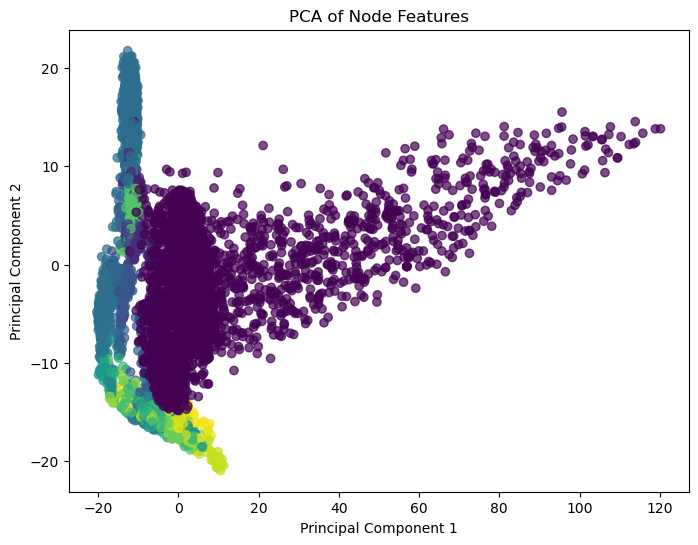

In [130]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings2)

colors = data.y

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7, c=colors)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Node Features')
plt.show()

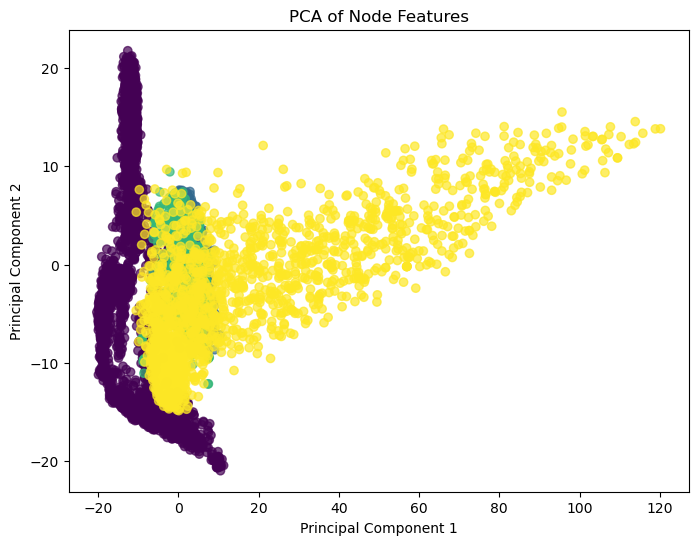

In [131]:
node_labelling = {
    'legal_entity': 0,
    'procurement': 1,
    'natural_person': 2,
    'okved': 3
}
labels = [node_labelling[G.nodes[node]["type"]] for node in G.nodes()]


pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings2)

colors = labels

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7, c=colors)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Node Features')
plt.show()

In [132]:
node_labelling = {
    'legal_entity': 0,
    'procurement': 1,
    'natural_person': 2,
    'okved': 3
}
# labels = [node_labelling[G.nodes[node]["type"]] for node in G.nodes()]
labels = data.y
X_train, X_test, y_train, y_test = train_test_split(embeddings2, labels, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

accuracy = clf.score(X_test, y_test)
accuracy

0.9747474747474747

In [133]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

labels = data.y
X_train, X_test, y_train, y_test = train_test_split(embeddings1, labels, test_size=0.2, random_state=42)

X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

input_size = X_train.shape[1]
hidden_size = 32
output_size = len(set(labels))
model = NeuralNetwork(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in tqdm(range(20)):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    accuracy = accuracy_score(y_test, predicted.numpy())
accuracy

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:08<00:00,  3.41s/it]


0.9591750841750841

In [134]:
embeddings2

tensor([[-2.9725,  4.7382,  3.9425,  ..., -2.3716,  2.2002,  7.7095],
        [-0.4839,  2.6207,  4.1722,  ...,  3.2096, -2.4734,  4.2957],
        [-0.8093,  2.7835,  3.4535,  ...,  1.9892, -2.8971,  5.5580],
        ...,
        [-1.8820,  1.4789,  2.5667,  ...,  1.9831, -1.9009, -0.5724],
        [-2.0110,  1.4587,  2.7233,  ...,  2.3121, -2.2974, -1.3087],
        [-4.0108,  3.9907,  6.2266,  ...,  2.5250, -3.3193, -1.0707]])

# TAGConv (2017)

In [135]:
data

Data(x=[11879, 23], edge_index=[2, 103319], y=[11879])

In [136]:
from torch_geometric.nn import TAGConv

class TAG(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats, num_classes):
        super(TAG, self).__init__()
        self.conv1 = TAGConv(in_feats, hidden_feats)
        self.conv2 = TAGConv(hidden_feats, out_feats)
        self.fc = nn.Linear(out_feats, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        h = self.conv1(x, edge_index)
        h = F.relu(h)
        h = self.conv2(h, edge_index)
        embeddings = h  # Эмбеддинги после прохождения через сверточные слои
        h = self.fc(h)
        return h, embeddings

# Параметры модели
in_feats = data.x.shape[1]  # Примерное количество признаков после предобработки
hidden_feats = 16
out_feats = 32
num_classes = len(region)

# Создание модели
model = TAG(in_feats, hidden_feats, out_feats, num_classes)

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Функция обучения модели
def train_model(model, data, criterion, optimizer, num_epochs=300):
    model.train()
    for epoch in tqdm(range(num_epochs)):
        optimizer.zero_grad()
        output, _ = model(data)
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 50 == 0:
            print(f'Epoch {epoch + 1}, Loss = {loss.item()}')


train_model(model, data, criterion, optimizer)

 17%|█████████████▊                                                                   | 51/300 [00:05<00:29,  8.34it/s]

Epoch 50, Loss = 0.7252107262611389


 34%|██████████████████████████▉                                                     | 101/300 [00:11<00:23,  8.52it/s]

Epoch 100, Loss = 0.3392814099788666


 50%|████████████████████████████████████████▎                                       | 151/300 [00:17<00:18,  8.19it/s]

Epoch 150, Loss = 0.22046442329883575


 67%|█████████████████████████████████████████████████████▌                          | 201/300 [00:24<00:12,  8.09it/s]

Epoch 200, Loss = 0.1707996279001236


 84%|██████████████████████████████████████████████████████████████████▉             | 251/300 [00:30<00:06,  7.63it/s]

Epoch 250, Loss = 0.14537754654884338


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:37<00:00,  8.03it/s]

Epoch 300, Loss = 0.13015753030776978


In [137]:
from sklearn.metrics import accuracy_score

# Предсказание и вычисление метрик
def evaluate_model(model, data):
    model.eval()
    with torch.no_grad():
        outputs, embeddings = model(data)
        predictions = torch.argmax(outputs, dim=1)
        targets = data.y
        accuracy = accuracy_score(targets.numpy(), predictions.numpy())
        print(f'Accuracy: {accuracy}')
    return embeddings, predictions.numpy()

embeddings3, predictions = evaluate_model(model, data)

Accuracy: 0.9765131745096388


In [138]:
embeddings3.shape

torch.Size([11879, 32])

In [139]:
import torch
from sklearn.metrics import classification_report

true_labels = data.y.cpu().numpy() # Истинные метки классов
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7016
           1       0.96      1.00      0.98        24
           2       1.00      0.93      0.97        15
           3       1.00      1.00      1.00        18
           4       1.00      1.00      1.00         9
           5       0.85      1.00      0.92        51
           6       1.00      0.44      0.62        18
           7       1.00      1.00      1.00        32
           8       0.90      0.90      0.90        30
           9       1.00      0.96      0.98        28
          10       0.95      0.95      0.95        57
          11       0.00      0.00      0.00         1
          12       0.75      0.82      0.78        11
          13       0.90      1.00      0.95         9
          14       0.93      0.95      0.94        56
          15       0.55      0.81      0.65        36
          16       1.00      0.23      0.38        39
          17       0.83    

D:\Program Files\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


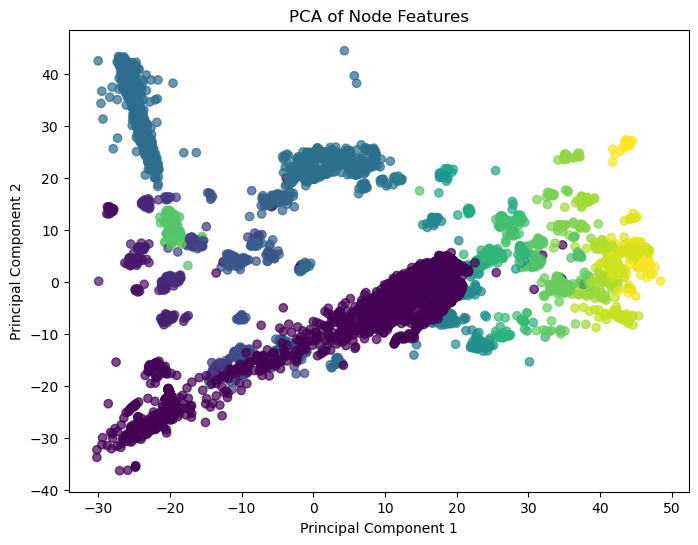

In [140]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings3)

colors = data.y

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7, c=colors)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Node Features')
plt.show()

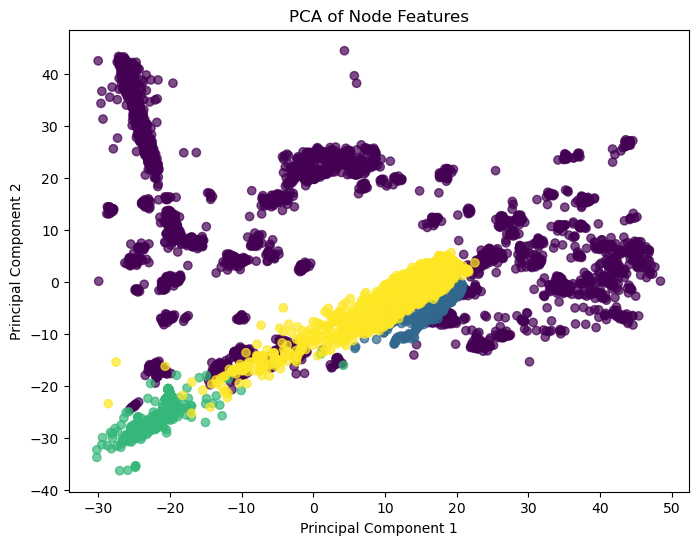

In [141]:
node_labelling = {
    'legal_entity': 0,
    'procurement': 1,
    'natural_person': 2,
    'okved': 3
}
labels = [node_labelling[G.nodes[node]["type"]] for node in G.nodes()]


pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings3)

colors = labels

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7, c=colors)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Node Features')
plt.show()

In [142]:
node_labelling = {
    'legal_entity': 0,
    'procurement': 1,
    'natural_person': 2,
    'okved': 3
}
# labels = [node_labelling[G.nodes[node]["type"]] for node in G.nodes()]
labels = data.y
X_train, X_test, y_train, y_test = train_test_split(embeddings3, labels, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

accuracy = clf.score(X_test, y_test)
accuracy

0.9835858585858586

In [143]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

input_size = X_train.shape[1]
hidden_size = 32
output_size = len(set(labels))
model = NeuralNetwork(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in tqdm(range(30)):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    accuracy = accuracy_score(y_test, predicted.numpy())
accuracy

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [01:26<00:00,  2.87s/it]


0.9739057239057239

In [144]:
embeddings3

tensor([[  6.9596,  10.3951, -13.5911,  ...,  -2.9281,  -4.5694,  13.0941],
        [  0.4130,  10.4530,  -8.6745,  ...,   0.8473,  -7.1459,  14.7981],
        [  2.7844,  11.7559, -10.4557,  ...,  -2.0155,  -8.0150,  14.0683],
        ...,
        [-14.2905,   8.1906,  -5.0448,  ...,   9.5372, -12.7747,  14.5178],
        [-13.8830,   8.1222,  -4.5723,  ...,   7.8565, -12.9331,  13.7762],
        [ -6.9532,   3.2318,  -4.6103,  ...,   5.8142,  -3.7240,   7.6788]])

# ARMAConv 2019

In [145]:
data

Data(x=[11879, 23], edge_index=[2, 103319], y=[11879])

In [146]:
from torch_geometric.nn import ARMAConv

class ARMA(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats, num_classes):
        super(ARMA, self).__init__()
        self.conv1 = ARMAConv(in_feats, hidden_feats)
        self.conv2 = ARMAConv(hidden_feats, out_feats)
        self.fc = nn.Linear(out_feats, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        h = self.conv1(x, edge_index)
        h = F.relu(h)
        h = self.conv2(h, edge_index)
        embeddings = h  # Эмбеддинги после прохождения через сверточные слои
        h = self.fc(h)
        return h, embeddings

# Параметры модели
in_feats = data.x.shape[1]  # Примерное количество признаков после предобработки
hidden_feats = 16
out_feats = 32
num_classes = len(region)

# Создание модели
model = ARMA(in_feats, hidden_feats, out_feats, num_classes)

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Функция обучения модели
def train_model(model, data, criterion, optimizer, num_epochs=300):
    model.train()
    for epoch in tqdm(range(num_epochs)):
        optimizer.zero_grad()
        output, _ = model(data)
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 50 == 0:
            print(f'Epoch {epoch + 1}, Loss = {loss.item()}')

train_model(model, data, criterion, optimizer)

 17%|█████████████▊                                                                   | 51/300 [00:05<00:25,  9.76it/s]

Epoch 50, Loss = 0.8775396347045898


 34%|███████████████████████████▏                                                    | 102/300 [00:10<00:21,  9.15it/s]

Epoch 100, Loss = 0.35698091983795166


 50%|████████████████████████████████████████▎                                       | 151/300 [00:16<00:16,  8.99it/s]

Epoch 150, Loss = 0.2025470733642578


 67%|█████████████████████████████████████████████████████▌                          | 201/300 [00:22<00:11,  8.58it/s]

Epoch 200, Loss = 0.13672760128974915


 84%|██████████████████████████████████████████████████████████████████▉             | 251/300 [00:27<00:05,  8.66it/s]

Epoch 250, Loss = 0.1015615463256836


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:33<00:00,  8.84it/s]

Epoch 300, Loss = 0.07954714447259903


In [147]:
from sklearn.metrics import accuracy_score

# Предсказание и вычисление метрик
def evaluate_model(model, data):
    model.eval()
    with torch.no_grad():
        outputs, embeddings = model(data)
        predictions = torch.argmax(outputs, dim=1)
        targets = data.y
        accuracy = accuracy_score(targets.numpy(), predictions.numpy())
        print(f'Accuracy: {accuracy}')
    return embeddings, predictions.numpy()

embeddings4, predictions = evaluate_model(model, data)

Accuracy: 0.9872043101271151


In [148]:
embeddings4.shape

torch.Size([11879, 32])

In [149]:
import torch
from sklearn.metrics import classification_report

true_labels = data.y.cpu().numpy() # Истинные метки классов
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7016
           1       1.00      1.00      1.00        24
           2       1.00      1.00      1.00        15
           3       1.00      0.94      0.97        18
           4       1.00      0.89      0.94         9
           5       1.00      0.98      0.99        51
           6       0.94      0.94      0.94        18
           7       1.00      1.00      1.00        32
           8       0.91      0.97      0.94        30
           9       0.96      0.93      0.95        28
          10       0.98      0.96      0.97        57
          11       0.00      0.00      0.00         1
          12       0.75      0.82      0.78        11
          13       1.00      1.00      1.00         9
          14       0.95      0.96      0.96        56
          15       0.72      0.64      0.68        36
          16       0.76      0.64      0.69        39
          17       0.88    

D:\Program Files\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


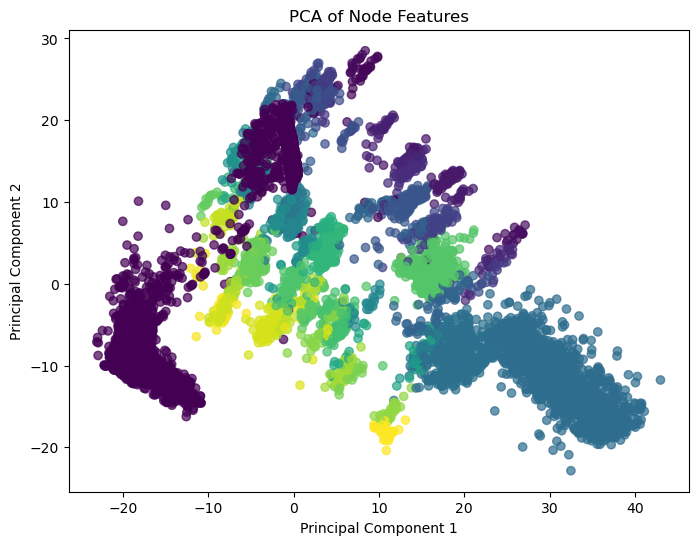

In [150]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings4)

colors = data.y

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7, c=colors)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Node Features')
plt.show()

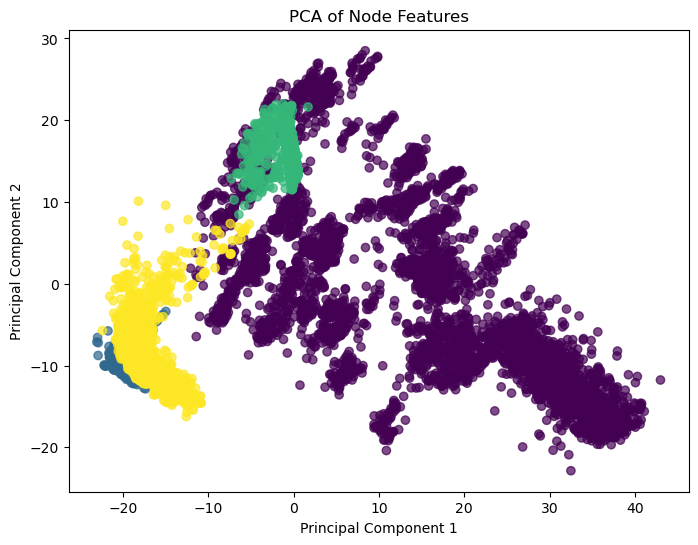

In [151]:
node_labelling = {
    'legal_entity': 0,
    'procurement': 1,
    'natural_person': 2,
    'okved': 3
}
labels = [node_labelling[G.nodes[node]["type"]] for node in G.nodes()]


pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings4)

colors = labels

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7, c=colors)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Node Features')
plt.show()

In [152]:
node_labelling = {
    'legal_entity': 0,
    'procurement': 1,
    'natural_person': 2,
    'okved': 3
}
# labels = [node_labelling[G.nodes[node]["type"]] for node in G.nodes()]
labels = data.y
X_train, X_test, y_train, y_test = train_test_split(embeddings4, labels, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

accuracy = clf.score(X_test, y_test)
accuracy

0.9831649831649831

In [153]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

input_size = X_train.shape[1]
hidden_size = 32
output_size = len(set(labels))
model = NeuralNetwork(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in tqdm(range(30)):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    accuracy = accuracy_score(y_test, predicted.numpy())
accuracy

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [01:50<00:00,  3.69s/it]


0.9734848484848485

In [154]:
embeddings4

tensor([[17.3526, 24.1947, 12.4706,  ...,  9.4952,  0.0000,  1.6835],
        [12.4393, 20.2407,  6.4479,  ...,  4.0089,  0.0000,  2.0075],
        [ 7.4366, 23.1484,  8.7964,  ...,  5.7497,  0.2318,  1.0857],
        ...,
        [ 3.2540,  6.4818, 10.6289,  ..., 15.7083, 10.3540,  7.7674],
        [ 3.6721,  6.9517,  9.2149,  ..., 13.8268,  9.9119,  7.0844],
        [ 3.5723,  2.0781,  6.6149,  ...,  6.6396,  6.4783,  7.9466]])

# SGConv

In [155]:
data

Data(x=[11879, 23], edge_index=[2, 103319], y=[11879])

In [156]:
from torch_geometric.nn import SGConv

class SG(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats, num_classes):
        super(SG, self).__init__()
        self.conv1 = SGConv(in_feats, hidden_feats)
        self.conv2 = SGConv(hidden_feats, out_feats)
        self.fc = nn.Linear(out_feats, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        h = self.conv1(x, edge_index)
        h = F.relu(h)
        h = self.conv2(h, edge_index)
        embeddings = h  # Эмбеддинги после прохождения через сверточные слои
        h = self.fc(h)
        return h, embeddings

# Параметры модели
in_feats = data.x.shape[1]  # Примерное количество признаков после предобработки
hidden_feats = 16
out_feats = 32
num_classes = len(region)

# Создание модели
model = SG(in_feats, hidden_feats, out_feats, num_classes)

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Функция обучения модели
def train_model(model, data, criterion, optimizer, num_epochs=300):
    model.train()
    for epoch in tqdm(range(num_epochs)):
        optimizer.zero_grad()
        output, _ = model(data)
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 50 == 0:
            print(f'Epoch {epoch + 1}, Loss = {loss.item()}')

train_model(model, data, criterion, optimizer)

 17%|██████████████                                                                   | 52/300 [00:04<00:21, 11.74it/s]

Epoch 50, Loss = 1.473811149597168


 34%|███████████████████████████▏                                                    | 102/300 [00:08<00:16, 12.20it/s]

Epoch 100, Loss = 1.0228525400161743


 51%|████████████████████████████████████████▌                                       | 152/300 [00:13<00:15,  9.85it/s]

Epoch 150, Loss = 0.7135549783706665


 67%|█████████████████████████████████████████████████████▌                          | 201/300 [00:17<00:08, 12.14it/s]

Epoch 200, Loss = 0.5779640078544617


 84%|██████████████████████████████████████████████████████████████████▉             | 251/300 [00:21<00:03, 12.33it/s]

Epoch 250, Loss = 0.5113325715065002


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:25<00:00, 11.70it/s]

Epoch 300, Loss = 0.4545648396015167


In [157]:
from sklearn.metrics import accuracy_score

# Предсказание и вычисление метрик
def evaluate_model(model, data):
    model.eval()
    with torch.no_grad():
        outputs, embeddings = model(data)
        predictions = torch.argmax(outputs, dim=1)
        targets = data.y
        accuracy = accuracy_score(targets.numpy(), predictions.numpy())
        print(f'Accuracy: {accuracy}')
    return embeddings, predictions.numpy()

embeddings5, predictions = evaluate_model(model, data)

Accuracy: 0.9066419732300699


In [158]:
embeddings5.shape

torch.Size([11879, 32])

In [159]:
import torch
from sklearn.metrics import classification_report

true_labels = data.y.cpu().numpy() # Истинные метки классов
print(classification_report(true_labels, predictions))

D:\Program Files\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7016
           1       0.70      0.79      0.75        24
           2       0.75      0.40      0.52        15
           3       0.86      0.33      0.48        18
           4       0.00      0.00      0.00         9
           5       0.55      0.55      0.55        51
           6       0.00      0.00      0.00        18
           7       0.96      0.69      0.80        32
           8       0.73      0.27      0.39        30
           9       0.58      0.68      0.62        28
          10       0.52      0.81      0.63        57
          11       0.00      0.00      0.00         1
          12       0.43      0.27      0.33        11
          13       0.00      0.00      0.00         9
          14       0.69      0.39      0.50        56
          15       0.50      0.06      0.10        36
          16       0.58      0.49      0.53        39
          17       0.00    

D:\Program Files\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


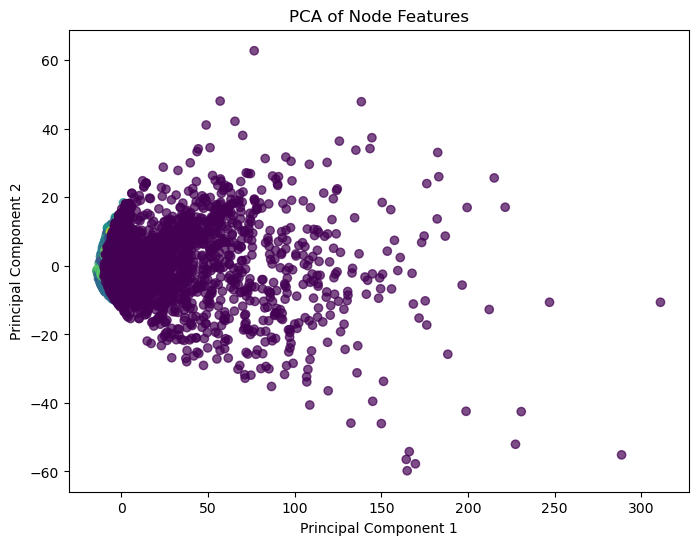

In [160]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings5)

colors = data.y

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7, c=colors)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Node Features')
plt.show()

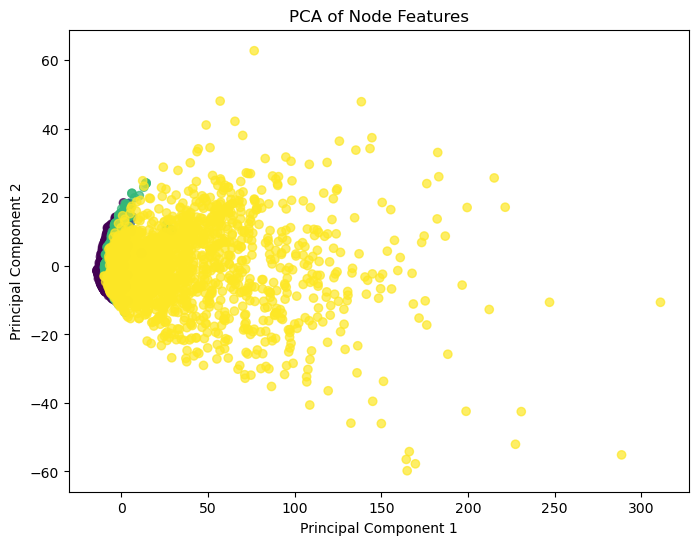

In [161]:
node_labelling = {
    'legal_entity': 0,
    'procurement': 1,
    'natural_person': 2,
    'okved': 3
}
labels = [node_labelling[G.nodes[node]["type"]] for node in G.nodes()]


pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings5)

colors = labels

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7, c=colors)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Node Features')
plt.show()

In [162]:
node_labelling = {
    'legal_entity': 0,
    'procurement': 1,
    'natural_person': 2,
    'okved': 3
}
# labels = [node_labelling[G.nodes[node]["type"]] for node in G.nodes()]
labels = data.y
X_train, X_test, y_train, y_test = train_test_split(embeddings5, labels, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

accuracy = clf.score(X_test, y_test)
accuracy

0.9465488215488216

In [163]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

input_size = X_train.shape[1]
hidden_size = 32
output_size = len(set(labels))
model = NeuralNetwork(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in tqdm(range(40)):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    accuracy = accuracy_score(y_test, predicted.numpy())
accuracy

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [02:55<00:00,  4.39s/it]


0.9095117845117845

In [164]:
embeddings5

tensor([[  3.2136,   2.0716,  -2.0311,  ...,   0.9217,  -2.9539,  -2.3936],
        [  1.3764,   0.5254,  -0.6373,  ...,   1.3543,  -1.7220,  -1.4200],
        [  3.0377,   0.9655,  -0.3002,  ...,   0.5914,  -2.1710,  -2.1233],
        ...,
        [ 15.0651,  -6.3301,  -6.1111,  ...,  -6.4188, -15.3312,  -8.0693],
        [ 15.7204,  -6.1864,  -5.1816,  ...,  -6.3504, -16.0320,  -8.9411],
        [  7.1938,   3.6487,  -4.2578,  ...,   0.2025,  -6.7119,  -5.4348]])

# node2vec

In [165]:
!pip install node2vec

In [166]:
import torch
import networkx as nx
import scipy.sparse as sp

In [167]:
from node2vec import Node2Vec
from sklearn.decomposition import PCA

node2vec = Node2Vec(G, dimensions=32, walk_length=10, p=1, q=2)
model = node2vec.fit(window=6)

Computing transition probabilities:   0%|          | 0/11879 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.50s/it]


In [171]:
embeddings = model.wv.vectors

pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

index_to_pos = {i: embeddings_pca[model.wv.index_to_key.index(i)] for i in model.wv.index_to_key}
nx.set_node_attributes(G, index_to_pos, 'pos')
pos = nx.get_node_attributes(G, 'pos')

In [172]:
embeddings.shape

(11879, 32)

In [173]:
len(pos)

11879

In [174]:
node_colors = {
    'legal_entity': 'blue',
    'procurement': 'green',
    'natural_person': 'red',
    'okved': 'yellow'
}
colors = [node_colors[G.nodes[node]['type']] for node in G.nodes()]

100%|████████████████████████████████████████████████████████████████████████| 103319/103319 [01:18<00:00, 1313.43it/s]


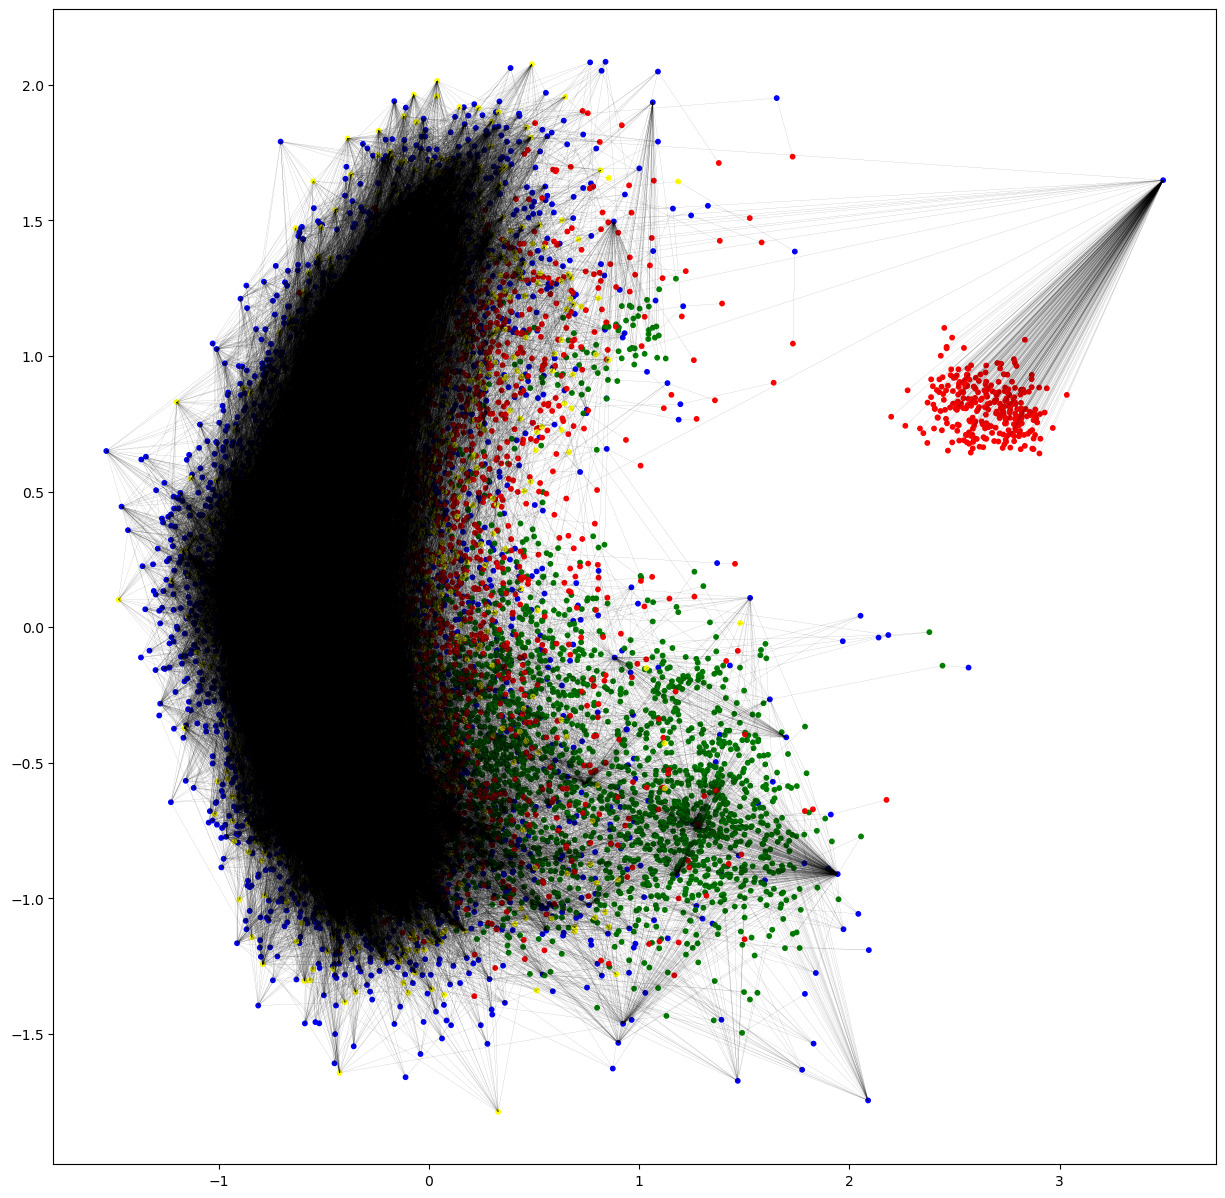

In [175]:
plt.figure(figsize=(15, 15))

for edge in tqdm(G.edges()):
    node1 = edge[0]
    node2 = edge[1]
    x1, y1 = pos[node1]
    x2, y2 = pos[node2]
    plt.plot([x1, x2], [y1, y2], 'k-', lw=0.05)

x_values, y_values = zip(*pos.values())
plt.scatter(x_values, y_values, color=colors, s=10)

plt.show()

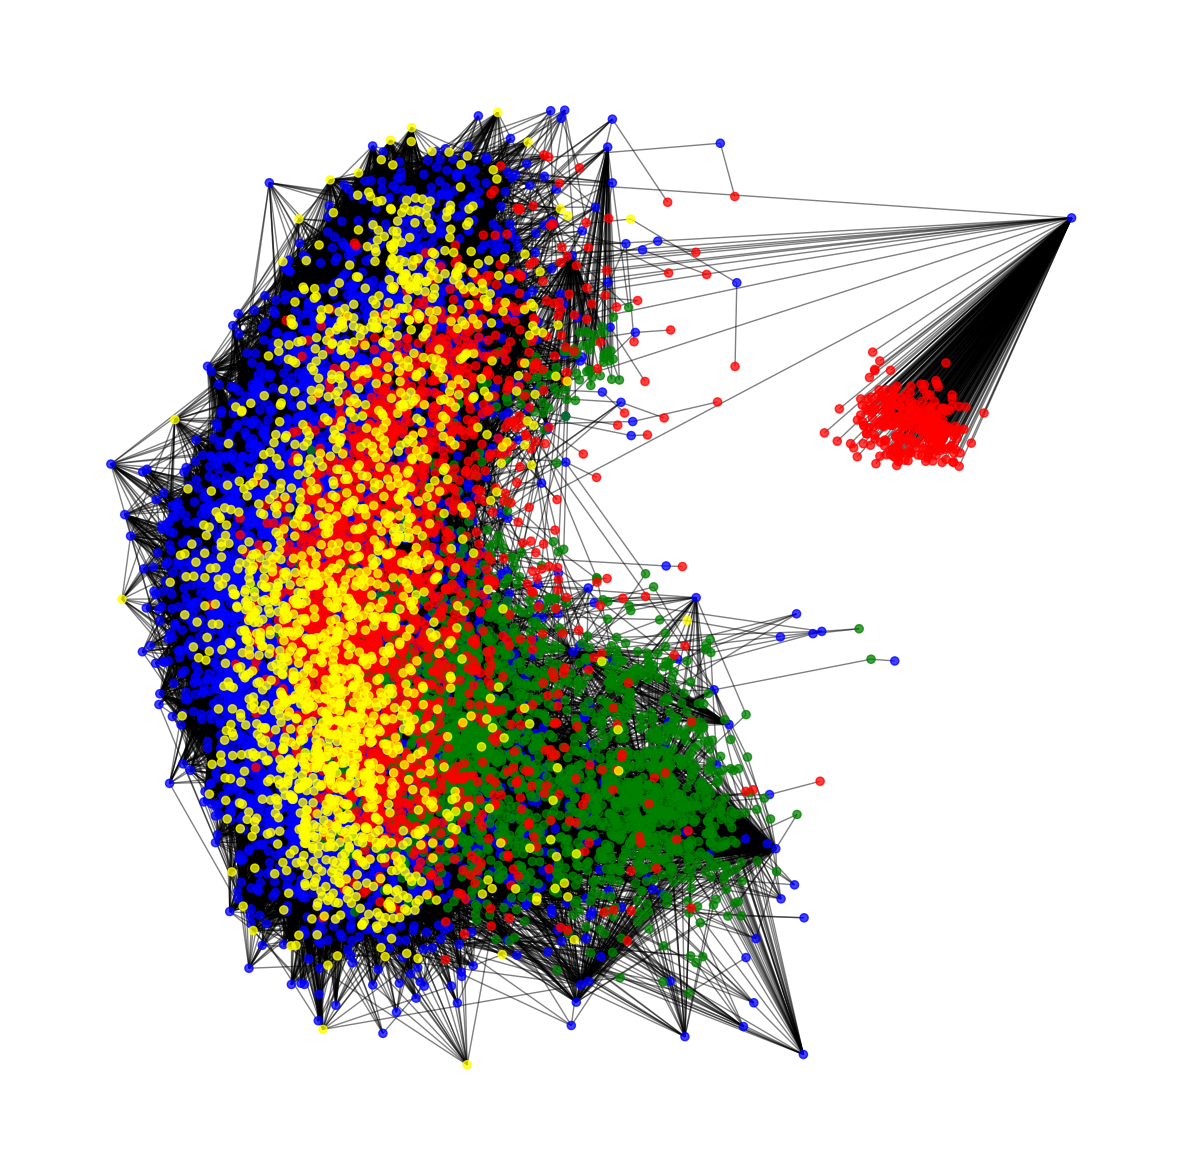

CPU times: total: 3.94 s
Wall time: 3.95 s


In [177]:
%%time
plt.figure(figsize=(15, 15))

nx.draw_networkx_nodes(G, pos, node_size=35, node_color = colors, alpha=0.75)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.axis("off")
plt.show()

In [178]:
node_labelling = {
    'legal_entity': 0,
    'procurement': 1,
    'natural_person': 2,
    'okved': 3
}
labels = [node_labelling[G.nodes[node]["type"]] for node in G.nodes()]

X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

accuracy = clf.score(X_test, y_test)
accuracy

0.742003367003367

In [179]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

input_size = X_train.shape[1]
hidden_size = 64
output_size = len(set(labels))
model = NeuralNetwork(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in tqdm(range(500)):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    accuracy = accuracy_score(y_test, predicted.numpy())
accuracy

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [04:22<00:00,  1.91it/s]


0.8261784511784511